# Index-Tracking Portfolio Optimization

# 1. Packages

In [25]:
# <-- Click In[66] to see code
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import pyswarms as ps
from empyrial import empyrial, Engine
from scipy.optimize import nnls
from datetime import date
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
from sklearn.decomposition import NMF
from tslearn.metrics import dtw
from pyswarms.utils.search.grid_search import GridSearch
from pyswarms.utils.search.random_search import RandomSearch
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 2. Data Collection

**Dates**

In [3]:
# <--
train_start = "2021-04-16"
train_end = "2021-07-15"
test_start = "2021-07-16"
test_end = "2021-08-16"

**Top 20 components and their weights**

In [159]:
available_cedears_list = ['AAPL', 'ABBV', 'AMD', 'ADBE', 'AMZN', 'BA', 'BAC', 'BB', 'BRK-B', 'C', 'CAT', 'CVX', 'COST', 'DIS', 'EBAY', 'FB', 'GE', 'GOLD', 'GOOGL', 'GS', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'PEP', 'PG', 'PYPL', 'QCOM', 'SBUX','SONY', 'TRIP', 'TSLA', 'TWTR', 'UGP', 'V', 'VZ', 'WFC', 'WMT', 'X', 'XOM']

# 3. Allocation with Non-negative Least Squares (NNLS) Optimization

The idea is to fit a linear combination of the current top 10 components against index prices in a constrained linear least squares model for the training period.

The coeffs obtained will then be non-negative. Each coeff is taken over the sum of coeffs as weightings for each component to be taken in the test period.

The sum of weightings will be the amount of leverage that the portfolio requires to replicate the index price.

The method is simple and intuitive, the goal is to find:
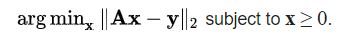

the algorithm used below is obtained from  Lawson, Charles L.; Hanson, Richard J. (1995). Solving Least Squares Problems. SIAM.

## 4.1 Using data since the latest reconstitution 
If we need to generate portfolio weightings for the month of April, we could use several months of training data since the last reconstitution date. However, if we needed to generate portfolio weightings right after the reconstitution, we might have to rely on prices from components which were not previously in the top 10 nor in the index.

**Prices as IVs**

In [5]:
# <--
# Train Val Test split

components20 = yf.download(tickers=available_cedears_list,
                start=train_start,
                end=test_end,
                interval="1d",
                group_by="column",
                auto_adjust=True,
                prepost=False,
                threads=True
              )['Close']

df = components20.copy()
df.dropna(inplace=True)

df['Actual Close'] = yf.download(tickers="SSO",
                start=train_start,
                end=test_end,
                interval="1d",
                group_by="column",
                auto_adjust=True,
                prepost=False,
                threads=True
              )['Close']

train = df[df.index <= train_end]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})


2021-08-21 21:34:11,733 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed


**Portfolio Allocation**

NNLS Residual 8.92102


,Component,Weight(%)
0,WFC,53.746867
1,X,26.426504
2,MSFT,6.921561
3,FB,6.734219
4,NVDA,2.786632
5,ADBE,2.478209
6,TSLA,0.657313
7,GOOGL,0.248694
8,NFLX,0.000000
9,PEP,0.000000



Portfolio Allocation:

Portfolio Simulated Close = 
1.1677(0.0*AAPL + 0.0*ABBV + 0.02478*ADBE + 0.0*AMD + 0.0*AMZN + 0.0*BA + 0.0*BAC + 0.0*BB + 0.0*BRK-B + 0.0*C + 0.0*CAT + 0.0*COST + 0.0*CVX + 0.0*DIS + 0.0*EBAY + 0.06734*FB + 0.0*GE + 0.0*GOLD + 0.00249*GOOGL + 0.0*GS + 0.0*INTC + 0.0*JNJ + 0.0*JPM + 0.0*KO + 0.0*MCD + 0.0*MMM + 0.0*MRK + 0.06922*MSFT + 0.0*NFLX + 0.02787*NVDA + 0.0*PEP + 0.0*PFE + 0.0*PG + 0.0*PYPL + 0.0*QCOM + 0.0*SBUX + 0.0*SONY + 0.0*SPOT + 0.0*TRIP + 0.00657*TSLA + 0.0*TWTR + 0.0*UGP + 0.0*V + 0.0*VZ + 0.53747*WFC + 0.0*WMT + 0.26427*X + 0.0*XOM)

Leverage Factor: 1.1676973623900795


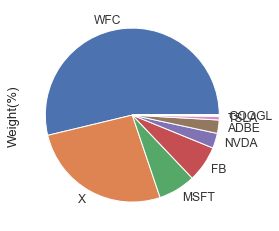

In [44]:
# <--
# Obtain coeffs from NNLS training
def get_portfolio_allocation(trainX, trainY, verbose=True):
    result = nnls(trainX, trainY)

    leverage_factor = sum(result[0])
    weights = result[0] / leverage_factor
    weights = dict(zip(trainX.columns, weights))

    s1 = str(round(leverage_factor,5))+"("
    for component in weights.keys():
        s1 += str(round(weights[component],5))+'*'+component+" + "
    s1 = s1[:-3]+")"

    if (verbose):
        print('NNLS Residual', round(result[1],5))
        allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
        allocation.set_index('Component',inplace=True)
        allocation.plot.pie(y='Weight(%)',legend=None)
        allocation.reset_index(inplace=True)
        display(allocation)
        print("\nPortfolio Allocation:")
        print('\nPortfolio Simulated Close = ')
        print(s1)
        print("\nLeverage Factor:", leverage_factor)
    return leverage_factor, weights

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

**Check for multicollinearity**

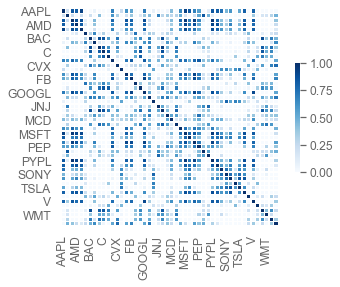

In [7]:
# <--
corr = trainX.corr()
sns.heatmap(corr,cmap="Blues",vmin=0,square=True,linewidths=.5,cbar_kws={"shrink": .5});

The coeffs estimate the effect of a single IV on the DV, holding other IVs constant. Since there is high multicollinearity, it causes imprecise estimates of coeffs, and the val and test coeffs will also be imprecise. This could lead to large errors in extrapolation.

**Validation Results**

In [8]:
# <--
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))


In [9]:
def evaluate(df,portfolio_col):
    df2 = pd.DataFrame({
        'Actual Daily Return':df['Actual Close'].pct_change()
    })

    index_hpr = (df['Actual Close'][-1] - df['Actual Close'][0]) / df['Actual Close'][0]

    portfolio_hpr = (df[portfolio_col][-1] - df[portfolio_col][0]) / df[portfolio_col][0]
    portfolio_active_return = portfolio_hpr - index_hpr

    portfolio_return = df[portfolio_col].pct_change().dropna()
    actual_return = df['Actual Close'].pct_change().dropna()
    portfolio_tracking_error = np.std(portfolio_return - actual_return)
    info_ratio = portfolio_active_return / portfolio_tracking_error
    print("\nCurrent Portfolio")
    print("*"*30)
    print("Active Return:", round(portfolio_active_return,5))
    print("Tracking Error:", round(portfolio_tracking_error*10000), " bps")
    print("Information Ratio:", round(info_ratio,5))
    print("Price RMSE:", mean_squared_error(df[portfolio_col],df['Actual Close'],squared=False))
    colname = portfolio_col[:-6]+" Daily Return"
    df2[colname] = df[portfolio_col].pct_change()
    df2.dropna(inplace=True)
    print("Returns RMSE:", mean_squared_error(df2[colname],df2['Actual Daily Return'],squared=False))

    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
    df.plot(ax=axs[0])
    df2.plot(ax=axs[1])


Current Portfolio
******************************
Active Return: 0.00425
Tracking Error: 60  bps
Information Ratio: 0.7133
Price RMSE: 0.5484287153399106
Returns RMSE: 0.005966304609397632


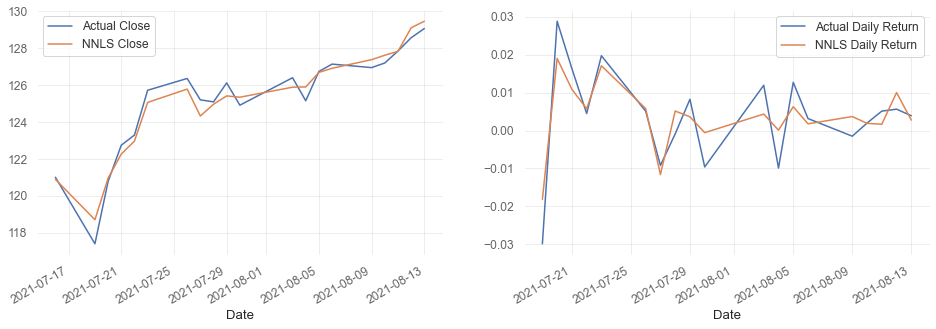

In [10]:
evaluate(testY,'NNLS Close')

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed
NNLS Residual 8.92102

Portfolio Allocation:


,Component,Weight(%)
0,WFC,53.746867
1,X,26.426504
2,MSFT,6.921561
3,FB,6.734219
4,NVDA,2.786632
5,ADBE,2.478209
6,TSLA,0.657313
7,GOOGL,0.248694
8,NFLX,0.000000
9,PEP,0.000000



Portfolio Simulated Close = 
1.1677(0.0*AAPL + 0.0*ABBV + 0.02478*ADBE + 0.0*AMD + 0.0*AMZN + 0.0*BA + 0.0*BAC + 0.0*BB + 0.0*BRK-B + 0.0*C + 0.0*CAT + 0.0*COST + 0.0*CVX + 0.0*DIS + 0.0*EBAY + 0.06734*FB + 0.0*GE + 0.0*GOLD + 0.00249*GOOGL + 0.0*GS + 0.0*INTC + 0.0*JNJ + 0.0*JPM + 0.0*KO + 0.0*MCD + 0.0*MMM + 0.0*MRK + 0.06922*MSFT + 0.0*NFLX + 0.02787*NVDA + 0.0*PEP + 0.0*PFE + 0.0*PG + 0.0*PYPL + 0.0*QCOM + 0.0*SBUX + 0.0*SONY + 0.0*SPOT + 0.0*TRIP + 0.00657*TSLA + 0.0*TWTR + 0.0*UGP + 0.0*V + 0.0*VZ + 0.53747*WFC + 0.0*WMT + 0.26427*X + 0.0*XOM)

Leverage Factor: 1.1676973623900795

Current Portfolio
******************************
Active Return: -0.0251
Tracking Error: 69  bps
Information Ratio: -3.66128
Price RMSE: 1.5696505192250425
Returns RMSE: 0.0069647912509791104


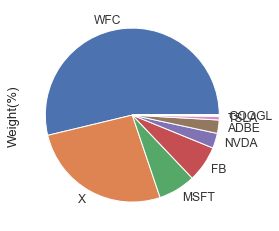

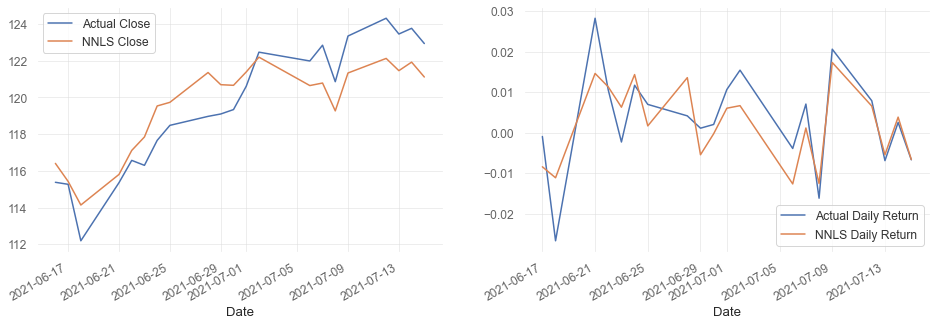

In [18]:
# REVISO CORRIENDO UN MES PARA ATRAS
# EL RESTO QUEDA IGUAL, ENTRENO 3 MESES, TESTEO 1 MES
train_start = "2021-02-16"
train_end = "2021-06-15"
test_start = "2021-06-16"
test_end = "2021-07-16"

components20 = yf.download(tickers=available_cedears_list,
                start=train_start,
                end=test_end,
                interval="1d",
                group_by="column",
                auto_adjust=True,
                prepost=False,
                threads=True
              )['Close']

df = components20.copy()
df.dropna(inplace=True)

df['Actual Close'] = yf.download(tickers="SSO",
                start=train_start,
                end=test_end,
                interval="1d",
                group_by="column",
                auto_adjust=True,
                prepost=False,
                threads=True
              )['Close']

train = df[df.index <= train_end]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))

evaluate(testY,'NNLS Close')

### Reviso metricas de este portafolio

Start date: 2021-06-16
End date: 2021-08-21


,Backtest
,
Annual return,46.34%
Cumulative return,7.2%
Annual volatility,30.1 %
Winning day ratio,60.87%
Sharpe ratio,1.41
Calmar ratio,8.29
Information ratio,0.0
Stability,0.73
Max Drawdown,-7.44 %


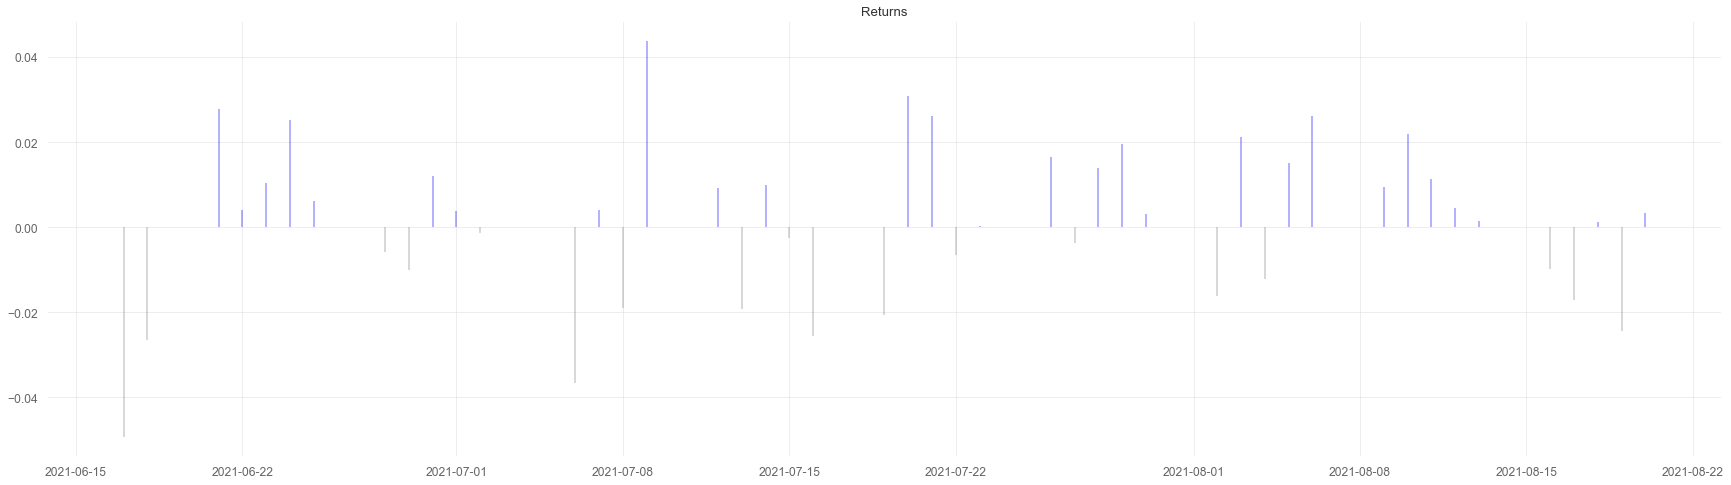

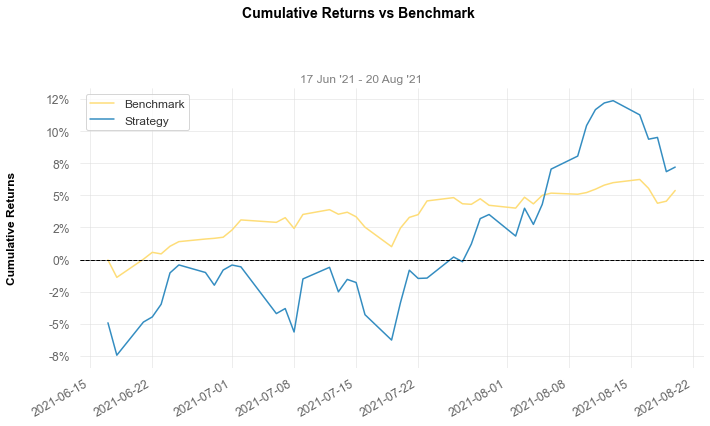

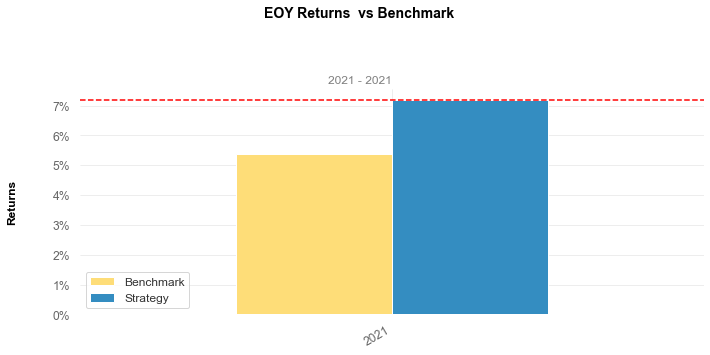

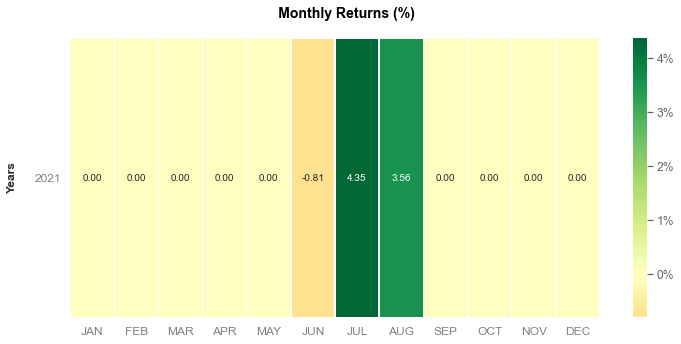

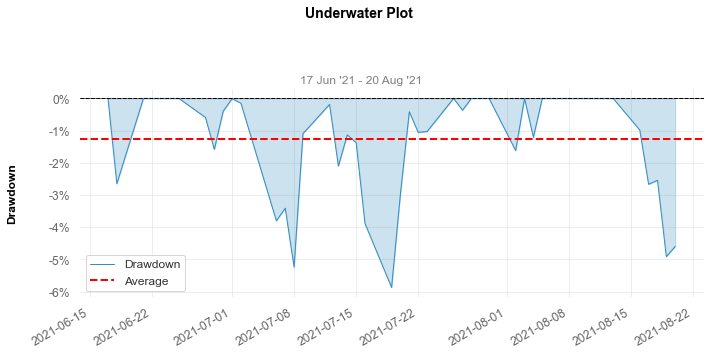

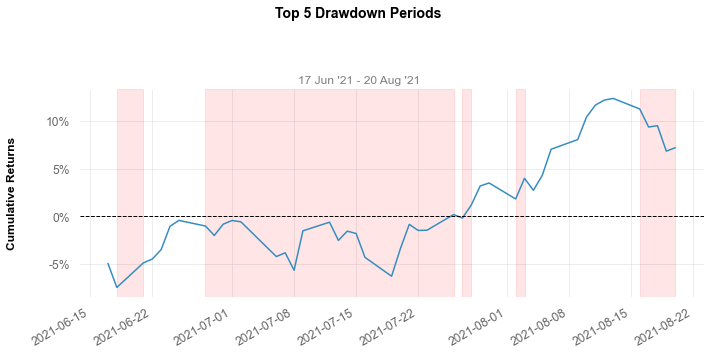

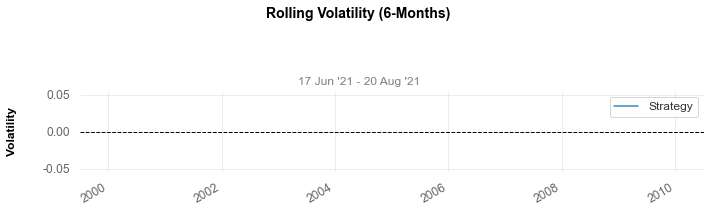

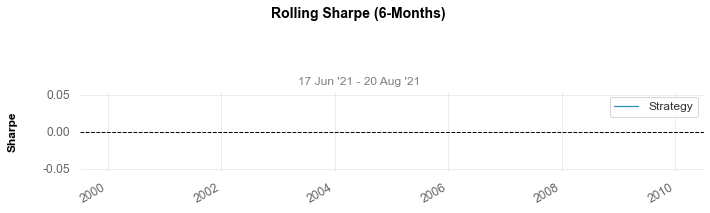

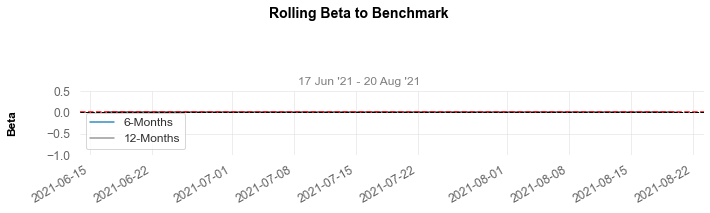

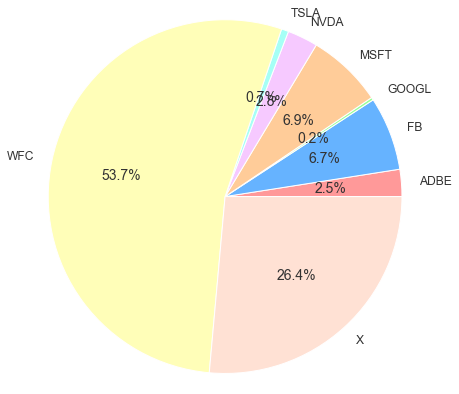

(None, None, None, None, None, None, None, None, None)

In [20]:
portfolio = Engine(
  start_date=test_start,
  portfolio=list(weights.keys()),
  weights=list(weights.values()),
  benchmark = ["SPY"]
)

empyrial(portfolio)

# 4. Busco los periodos optimos de entrenamiento / testeo

In [23]:
def evaluate_tracking_error(df,portfolio_col):
    portfolio_return = df[portfolio_col].pct_change().dropna()
    actual_return = df['Actual Close'].pct_change().dropna()
    portfolio_tracking_error = np.std(portfolio_return - actual_return)

    return round(portfolio_tracking_error*10000)

In [195]:
def train_model(components, train_start, train_end, test_start, test_end):

  df = components.copy()

  train = df[(df.index >= train_start) & (df.index <= train_end)]
  test = df[(df.index >= test_start) & (df.index <= test_end)]

  trainX = train.drop('Actual Close', axis=1)
  trainY = train['Actual Close']
  testX = test.drop('Actual Close', axis=1)
  testY = pd.DataFrame({'Actual Close':test['Actual Close']})

  leverage_factor, weights = get_portfolio_allocation(trainX, trainY, verbose=False)
  testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))

  return evaluate_tracking_error(testY,'NNLS Close')

In [218]:
# training iterator
def training_iterator(components, train_months, test_months):
  array_tracking_errors = []
  train_start = date.fromisoformat(START_DATE)
  train_end = date.fromisoformat(START_DATE) + relativedelta(months=train_months)
  test_start = train_end + relativedelta(days=1)
  test_end = test_start + relativedelta(months=test_months)

  while test_end < date.fromisoformat(END_DATE):
    array_tracking_errors.append(
      train_model(
        components,
        train_start.isoformat(),
        train_end.isoformat(),
        test_start.isoformat(),
        test_end.isoformat()
      )
    )

    train_start += relativedelta(months=1)
    train_end += relativedelta(months=1)
    test_start += relativedelta(months=1)
    test_end += relativedelta(months=1)

  return np.array(array_tracking_errors)


## 4.1 Comparo periodos de entrenamiento

In [259]:
START_DATE = '2016-01-01'
END_DATE = '2021-08-01'

components = yf.download(tickers=available_cedears_list,
                start=START_DATE,
                end=END_DATE,
                interval="1d",
                group_by="column",
                auto_adjust=True,
                prepost=False,
                threads=True
              )['Close']

components['Actual Close'] = yf.download(tickers="SSO",
                  start=START_DATE,
                  end=END_DATE,
                  interval="1d",
                  group_by="column",
                  auto_adjust=True,
                  prepost=False,
                  threads=True
                )['Close']

max_train_months = 18
max_test_months = 18

results = pd.DataFrame(columns=['months_train', 'months_test', 'min', 'max', 'mean', 'median', 'q60', 'q75', 'q90', 'sample_size'])

for i in range(1, max_train_months+1):
  for j in range(1, max_test_months+1):
    tracking_errors = training_iterator(components, i, j)
    results = results.append({
      'months_train': i,
      'months_test': j,
      'min': tracking_errors.min(),
      'max': tracking_errors.max(),
      'mean': tracking_errors.mean(),
      'median': np.quantile(tracking_errors, 0.5),
      'q60': np.quantile(tracking_errors, 0.6),
      'q75': np.quantile(tracking_errors, 0.75),
      'q90': np.quantile(tracking_errors, 0.90),
      'sample_size': len(tracking_errors)
    }, ignore_index=True)

results

[*********************100%***********************]  47 of 47 completed
[*********************100%***********************]  1 of 1 completed


,months_train,months_test,min,max,mean,median,q60,q75,q90,sample_size
0,1.0,1.0,32.0,589.0,96.030769,73.0,85.0,112.00,146.4,65.0
1,1.0,2.0,39.0,461.0,99.828125,87.0,91.8,110.75,138.5,64.0
2,1.0,3.0,45.0,411.0,106.492063,86.0,97.2,110.00,147.6,63.0
3,1.0,4.0,51.0,363.0,109.580645,89.0,95.0,111.75,167.6,62.0
4,1.0,5.0,51.0,336.0,112.344262,90.0,96.0,120.00,190.0,61.0
...,...,...,...,...,...,...,...,...,...,...
319,18.0,14.0,73.0,193.0,127.285714,92.0,154.6,180.00,190.6,35.0
320,18.0,15.0,74.0,190.0,128.294118,91.0,165.8,182.50,186.0,34.0
321,18.0,16.0,78.0,186.0,129.484848,91.0,169.6,179.00,182.6,33.0
322,18.0,17.0,78.0,183.0,129.656250,127.0,169.6,176.00,179.0,32.0


In [275]:
results.sort_values('mean').head(20)

,months_train,months_test,min,max,mean,median,q60,q75,q90,sample_size
18,2.0,1.0,30.0,589.0,88.750000,72.0,75.8,104.50,135.8,64.0
36,3.0,1.0,28.0,608.0,88.968254,72.0,82.0,103.00,134.2,63.0
54,4.0,1.0,30.0,462.0,89.096774,74.0,86.8,115.75,143.3,62.0
108,7.0,1.0,35.0,462.0,89.491525,69.0,85.2,109.00,152.6,59.0
72,5.0,1.0,33.0,460.0,90.311475,68.0,93.0,110.00,143.0,61.0
90,6.0,1.0,32.0,464.0,91.083333,70.0,92.2,110.00,152.2,60.0
126,8.0,1.0,32.0,462.0,91.206897,73.5,84.0,110.50,157.0,58.0
144,9.0,1.0,33.0,482.0,91.842105,70.0,83.8,114.00,160.2,57.0
180,11.0,1.0,36.0,481.0,92.818182,71.0,84.0,116.50,161.6,55.0
198,12.0,1.0,35.0,462.0,93.092593,70.0,89.6,115.25,162.7,54.0


In [322]:
results[(results['q90']<=140.0) & (results['median']<=90.0) & (results['max'] <= 475.0)].sort_values('q75')

,months_train,months_test,min,max,mean,median,q60,q75,q90,sample_size
19,2.0,2.0,40.0,463.0,94.222222,79.0,86.2,98.50,134.4,63.0
37,3.0,2.0,37.0,474.0,94.532258,80.0,89.2,108.00,134.0,62.0
1,1.0,2.0,39.0,461.0,99.828125,87.0,91.8,110.75,138.5,64.0
